In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [2]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 
'''

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

import time
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from collections import Counter

from predicting_quantum_properties.prediction_shadow import estimate_exp
from modified_derandomization import modified_derandomized_classical_shadow

# handle deprecation issues
import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
h5py.get_config().default_file_mode = 'r'






# classically obtained ground state energy
EXPECTED_EIGENVALUE = -1.86

# specifying the geometry of the molecule in question
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
# Note: the qubit order in Qiskit string is qn qn-1 ... q1 q0
# while in Qikit circuit it is              q0 q1 ... qn-1 qn  (little endian)
mapper = BravyiKitaevMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)

print(bkencoded_hamiltonian)

-0.8105479805373264 * IIII
+ 0.17218393261915543 * IIIZ
- 0.22575349222402474 * IIZZ
+ 0.1209126326177664 * IIZI
+ 0.1721839326191556 * IZII
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
- 0.22575349222402485 * ZZZI
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [3]:
'''
FORMATTING THE HAMILTONIAN 
'''
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data


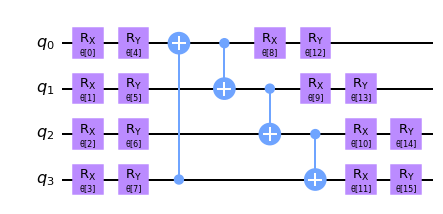

In [4]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [5]:
'''
FORMATTING THE HAMILTONIAN 
'''
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian:
    
        observable_str = str(observable)
        observable_str_list = observable_str.split('*')
        pauli_str_list = [obs.replace(' ', '') for obs in observable_str_list]
        
        tuple_list = []
    
        #for op_index, pauli_op in enumerate(pauli_str_list[1][::-1]):  # reversing the order of single-qubit Paulis for Qiskit 
        for op_index, pauli_op in enumerate(pauli_str_list[1]):
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                tuple_list.append((pauli_op, op_index))
        if len(tuple_list) > 0:
            hamiltonian_observables.append(tuple_list)
            hamiltonian_coefficients.append(float(pauli_str_list[0].strip()))

    #system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data

# variational ansatz
reps = 1
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)




def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits)
    
    #for idx, op in enumerate(pauli_op):
    for idx, op in zip(reversed(range(len(pauli_op))), pauli_op):    # reversing order of Pauli operators 
        if op == 'X':
            basis_change.h(idx)
        elif op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
        #elif op == 'Z':
        #    basis_change.id(idx)

    return basis_change



def min_cost():
    
    return min(cost_history)


def log_cost(cost):

    global cost_history
    cost_history.append(cost)
    
    


def objective_function(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc.compose(basis_change_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order qn qn-1 ... q1 q0

        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                snapshot.reverse()
                
                shadow.append(snapshot)
    
    
    cost = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost += weight * exp_val
            
    log_cost(cost)
    
    return cost


NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.8557807804833842
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.8557807804833842
50 | Counter({('X', 'X', 'X', 'X'): 50}) | 1.004219219516616
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8461616497286062
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8524133375260285
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8527810838670533
250 | Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4}) | 0.010019483284452603
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8188329444648101
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8215966593291315
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8250973648239384
500 | Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 8, ('Z', 'X', 'Z', 'X'): 1}) | 0.03824367912197372
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.836502792071802
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.80

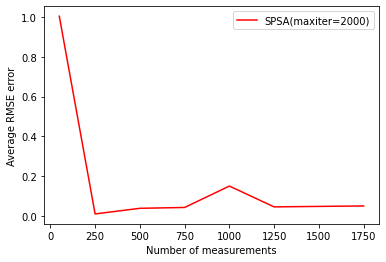

In [6]:
'''
RUNNING EXPERIMENTS
''' 

start_time = time.time()
rmse_errors = []

print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(observables_xyz, num_operators, 
                                                                      system_size, weight=absolute_coefficients)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)

    optimizer = SPSA(maxiter=2000) 
    cost_function = partial(objective_function, derandomized_hamiltonian)
    
    expectation_values = []
    num_experiments = 3


    for iteration in range(num_experiments):
        
        cost_history = []
        
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        minimal_cost = min_cost()
        expectation_values.append(minimal_cost)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, minimal_cost))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - EXPECTED_EIGENVALUE)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)